# Project 3: Multivariate Regression Analysis and Gradient Boosting with Lowess and XGB

## Abstract:

In this notebook I present two exmaples of Multivariate Regression Analysis and Gradient Boosting with Lowess, Random Forest Regression, a home-made boosted Lowess model, and  the Extreme Gradient Boosting method (XGB). I apply each method to an auto-MPG dataset, and a Boston Housing Prices dataset. I present conceptualizations of gradient boosting, and use KFold cross-validation to test each model. I found that for the MPG data, Extreme Gradient Boosting was the best option by a significant margin, and for Bston Housing data I found that the homemade gradient boosting method performed the best by a smaller margin.

In [1]:
#Imports
import numpy as np
import pandas as pd
from scipy.linalg import lstsq
from scipy.interpolate import interp1d, LinearNDInterpolator, NearestNDInterpolator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb 

## The Data

These data sets are both quite small, and I am using them as two dimensional. For the boston housing data, I have selected the 'cmedv', or the median sale price per zipcode, as our target and, since this is multivariate regression, I am using all 14 features. For the 'cars' dataset, I've selected the miles-per-gallon of each car as the target, and again are using all of the features. Below are examples of the data. Neither is a good candidate for a regular linear regression.

I did very little preprocessing on this data. It came quite well curated, so the only thing I needed to do was scale the features, for which I used scikitlearn's StandardScalar, and do a train test split (75% train, 25% test).

In [12]:
#Importing and Displaying Data

cars = pd.read_csv('Data/cars.csv')
boston = pd.read_csv('Data/Boston_Housing_Prices.csv')

Cars = np.concatenate([cars[['ENG','CYL','WGT']].values, cars['MPG'].values.reshape(-1,1)], axis=1)
Boston = np.concatenate([boston[['tract', 'longitude', 'latitude', 'crime', 'residential', 'industrial', 'nox', 'rooms', 'older', 
                                'distance', 'highway', 'tax', 'ptratio', 'lstat']].values, boston['cmedv'].values.reshape(-1,1)], axis=1)

model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)

print("Boston Housing Data:")
display(boston[['tract', 'longitude', 'latitude', 'crime', 'residential', 'industrial', 'nox', 'rooms', 'older', 
                                'distance', 'highway', 'tax', 'ptratio', 'lstat']].head())
print("Auto MPG Data:")
display(cars.head())

Boston Housing Data:


,tract,longitude,latitude,crime,residential,industrial,nox,rooms,older,distance,highway,tax,ptratio,lstat
0,2011,-70.955002,42.255001,0.00632,18.0,2.31,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98
1,2021,-70.949997,42.287498,0.02731,0.0,7.07,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14
2,2022,-70.935997,42.283001,0.02729,0.0,7.07,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03
3,2031,-70.928001,42.292999,0.03237,0.0,2.18,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94
4,2032,-70.921997,42.298000,0.06905,0.0,2.18,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33


Auto MPG Data:


,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449


## The Methods and Models

### Gradient Boosting, Generally
Put simply, to "boost" a known regression model (called a "weak learner") is to train $n$ other regression models to predict the original model's residual errors, then add these predicted residuals to the original models test output. This results in a reduced error in the test output. It is also important to know that the residuals of a linear regression weak learner are the gradients of the learner's loss function. This technique is called gradient boosting because it is predicting the loss function's gradient for each input observation, and adjusting the prediction accordingly.

### Extreme Gradient Boosting (XGB)
Extreme gradient boosting (XGB) is simply a prepackaged model type that uses some regularizations to improve gradient boosting techniques on weak learners. XGB uses decision trees for it's gradeint boosting, splitting the residuals at the average between each pair of nearest points, in each feature. These decision trees predict the residuals for the original "weak learner" not the target that the weak learner is intending to model.

Each decision tree split is optimized by attempting to find the highest "gain" which is an approximate measure of how much of a difference a given split would make in the predicted outcome. This calculation is below.

<figure>
<center>
<img src='Data/Gain_Calc_Img.png' 
width='500px' />
<img src='Data/Gain_Img.png' 
width='250px' />
<figcaption>Gain Calculation from Cory Maklin's Medium Post on XGB</figcaption></center>
</figure>


In this case, $\lambda$ and $\gamma$ are hyperparameters representing the tree's sensitivity to individual residuals, and the level of gain required to have a "significant" impact on the split. XGB then continues this process on each leaf of the tree, until the maximum depth is reached or the all of the leaves' gain become negative, indicating that further splits would not be useful in predicting the outcome. The ouput of the model is now:

$\large \hat y = (Weak Learner Predictions)(X) + (LearningRate)*(Booster Predictions)(X)$ 

Where the learning rate is a third hyper parameter.

Then, XGB repeats this entire process, treating the now boosted learner as another weak learner, until the number of estimators, or boosting decision trees, is reached. This is another hyperparamter, defaulted at 100, and makes XGB somewhat resource intensive compared to the weaklearner it is boosting.

In [6]:
#Tricubic Kernel, Lowess, and Boosted Lowess definitions

def Tricubic(x):
  if len(x.shape) == 1:
    x = x.reshape(-1,1)
  d = np.sqrt(np.sum(x**2,axis=1))
  return np.where(d>1,0,70/81*(1-d**3)**3)

def lw_reg(X, y, xnew, kern, tau, intercept):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    n = len(X) # the number of observations
    yest = np.zeros(n)

    if len(y.shape)==1: # here we make column vectors
      y = y.reshape(-1,1)
    if len(X.shape)==1:
      X = X.reshape(-1,1)
    if intercept:
      X1 = np.column_stack([np.ones((len(X),1)),X])
    else:
      X1 = X

    w = np.array([kern((X - X[i])/(2*tau)) for i in range(n)]) # here we compute n vectors of weights

    #Looping through all X-points, solving for the predictions as linear combinations of inputs and weights matrix
    for i in range(n):          
        W = np.diag(w[:,i])
        b = np.transpose(X1).dot(W).dot(y)
        A = np.transpose(X1).dot(W).dot(X1)
        #A = A + 0.001*np.eye(X1.shape[1]) # if we want L2 regularization
        #theta = linalg.solve(A, b) # A*theta = b
        beta, res, rnk, s = lstsq(A, b)
        yest[i] = np.dot(X1[i],beta)
    if X.shape[1]==1:
      f = interp1d(X.flatten(),yest,fill_value='extrapolate')
    else:
      f = LinearNDInterpolator(X, yest)
    output = f(xnew) # the output may have NaN's where the data points from xnew are outside the convex hull of X
    if sum(np.isnan(output))>0:
      g = NearestNDInterpolator(X,y.ravel()) 
      # output[np.isnan(output)] = g(X[np.isnan(output)])
      output[np.isnan(output)] = g(xnew[np.isnan(output)])
    return output   

def rep_boosted_lwr(X, y, xtest, kern, tau, booster, nboost, intercept):
  yhat = lw_reg(X,y,X,kern,tau,intercept) #get loess predictions on training data
  yhat_test = lw_reg(X,y,xtest,kern,tau,intercept) #get loess predictions on testing data
  lw_error = y - yhat #find the loess training residuals; these are what the booster will train on
  #Below, fit the booster on train data and residuals, then add its predictions to the train/test predictions, then get new residuals
  for i in range(nboost): 
    booster.fit(X, lw_error)
    yhat += booster.predict(X)
    yhat_test += booster.predict(xtest)
    lw_error = y - yhat
  return yhat_test

Above are definitions for the tricubic kernel, the loess regressor, and the homemade repeated loess booster.

### KFold Cross Validation Loops

Below are two KFold-Validation loops, one for each dataset. I ran each kfold validation for 5 different random states and with 10 splits per state to add a level of accuracy to the kfolds. Ideally I would try many more states, but I have hardware constaints that prevent that (laptop). I also provided a random forest regressor and an unboosted loess regressor for performance perspective. Also take note of the different scales of the MSE graphs.

I ran loess using th tricubic kernel and $\tau = 1.2$, the boosted method for loess used a random forest of 25 trees and max depth of 2, and repeated boosting 50 times, so there were 50 random forests boosting the loess weak learner. For XGB I used 100 estimators, $\lambda = 20$, $\gamma = 10$, learning rate $\alpha = 1$ and a max depth of 3.

In [32]:
#Cars Cross-Validation
mse_lwr = []
mse_blwr = []
mse_rf = []
mse_xgb = []

scale = StandardScaler()
for i in range(12345,12350):
  print('Random State: ' + str(i))
  kf = KFold(n_splits=10,shuffle=True,random_state=i)
  # this is the random state cross-validation loop to make sure our results are real, not just the state being good/bad for a particular model
  j = 0
  for idxtrain, idxtest in kf.split(Cars[:,:2]):
    j += 1
    #Split the train and test data
    xtrain = Cars[:,:2][idxtrain]
    ytrain = Cars[:,-1][idxtrain]
    ytest = Cars[:,-1][idxtest]
    xtest = Cars[:,:2][idxtest]
    xtrain = scale.fit_transform(xtrain)
    xtest = scale.transform(xtest)
    #print('Split Number: ' + str(j))

    #Train and predict for LWR and boosted LWR
    yhat_lwr = lw_reg(xtrain,ytrain, xtest,Tricubic,tau=1.2,intercept=True)
    
    #Boosted LWR with repeated boosting
    booster_rf = RandomForestRegressor(n_estimators=25,max_depth=2)
    yhat_blwr = rep_boosted_lwr(xtrain,ytrain,xtest,Tricubic,1.2,booster_rf,50,True)

    #Train and predict with random forest
    model_rf = RandomForestRegressor(n_estimators=100,max_depth=3)
    model_rf.fit(xtrain,ytrain)
    yhat_rf = model_rf.predict(xtest)

    #Train and predict for XGB
    model_xgb.fit(xtrain,ytrain)
    yhat_xgb = model_xgb.predict(xtest)

    #Append each model's MSE
    mse_lwr.append(mse(ytest,yhat_lwr))
    mse_blwr.append(mse(ytest,yhat_blwr))
    mse_rf.append(mse(ytest,yhat_rf))
    mse_xgb.append(mse(ytest,yhat_xgb))

print('\n The Results for the Auto MPG Dataset were:')
print('The Cross-validated Mean Squared Error for LWR is : '+str(np.mean(mse_lwr)))
print('The Cross-validated Mean Squared Error for BLWR is : '+str(np.mean(mse_blwr)))
print('The Cross-validated Mean Squared Error for RF is : '+str(np.mean(mse_rf)))
print('The Cross-validated Mean Squared Error for XGB is : '+str(np.mean(mse_xgb)))

Random State: 12345
Random State: 12346
Random State: 12347
Random State: 12348
Random State: 12349

 The Results for the Auto MPG Dataset were:
The Cross-validated Mean Squared Error for LWR is : 18.74002057325897
The Cross-validated Mean Squared Error for BLWR is : 16.53022990386176
The Cross-validated Mean Squared Error for RF is : 17.16940661838395
The Cross-validated Mean Squared Error for XGB is : 16.313673784632016


In [33]:
#Boston Cross-Validation
b_mse_lwr = []
b_mse_blwr = []
b_mse_rf = []
b_mse_xgb = []

scale = StandardScaler()
for i in range(12345,12350):
  print('Random State: ' + str(i))
  kf = KFold(n_splits=10,shuffle=True,random_state=i)
  # this is the random state cross-validation loop to make sure our results are real, not just the state being good/bad for a particular model
  j = 0
  for idxtrain, idxtest in kf.split(Cars[:,:13]):
    j += 1
    #Split the train and test data
    xtrain = Cars[:,:13][idxtrain]
    ytrain = Cars[:,-1][idxtrain]
    ytest = Cars[:,-1][idxtest]
    xtest = Cars[:,:13][idxtest]
    xtrain = scale.fit_transform(xtrain)
    xtest = scale.transform(xtest)
    #print('Split Number: ' + str(j))

    #Train and predict for LWR
    yhat_lwr = lw_reg(xtrain,ytrain, xtest,Tricubic,tau=1.2,intercept=True)
    
    #Boosted LWR with repeated boosting
    booster_rf = RandomForestRegressor(n_estimators=25,max_depth=2)
    yhat_blwr = rep_boosted_lwr(xtrain,ytrain,xtest,Tricubic,1.2,booster_rf,50,True)

    #Train and predict with random forest
    model_rf = RandomForestRegressor(n_estimators=100,max_depth=3)
    model_rf.fit(xtrain,ytrain)
    yhat_rf = model_rf.predict(xtest)

    #Train and predict for XGB
    model_xgb.fit(xtrain,ytrain)
    yhat_xgb = model_xgb.predict(xtest)

    #Append each model's MSE
    b_mse_lwr.append(mse(ytest,yhat_lwr))
    b_mse_blwr.append(mse(ytest,yhat_blwr))
    b_mse_rf.append(mse(ytest,yhat_rf))
    b_mse_xgb.append(mse(ytest,yhat_xgb))

print('\n The Results for the Boston Housing Prices Dataset were:')
print('The Cross-validated Mean Squared Error for LWR is : '+str(np.mean(b_mse_lwr)))
print('The Cross-validated Mean Squared Error for BLWR is : '+str(np.mean(b_mse_blwr)))
print('The Cross-validated Mean Squared Error for RF is : '+str(np.mean(b_mse_rf)))
print('The Cross-validated Mean Squared Error for XGB is : '+str(np.mean(b_mse_xgb)))

Random State: 12345
Random State: 12346
Random State: 12347
Random State: 12348
Random State: 12349

 The Results for the Boston Housing Prices Dataset were:
The Cross-validated Mean Squared Error for LWR is : 0.3587898269590638
The Cross-validated Mean Squared Error for BLWR is : 0.35878982695906686
The Cross-validated Mean Squared Error for RF is : 0.6298989243833981
The Cross-validated Mean Squared Error for XGB is : 0.5754137982172873


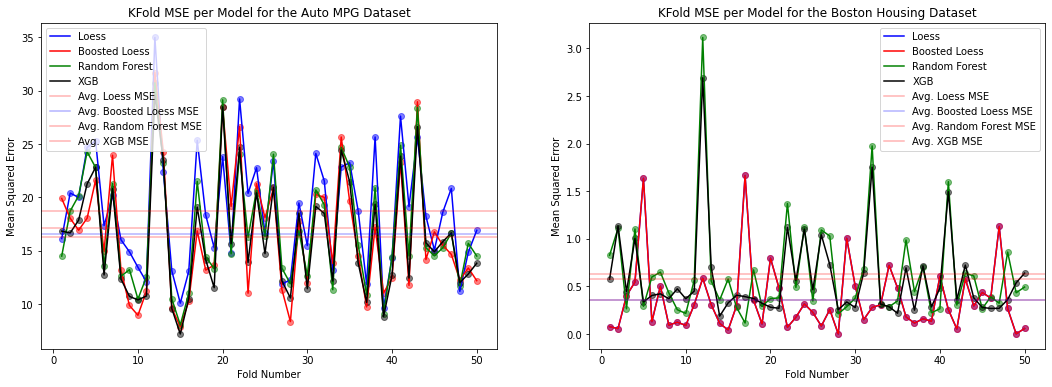

In [34]:
#ticks = np.arange(1,51)
fig, (cars_plot, boston_plot) = plt.subplots(1,2, figsize=(18,6))

#Cars Plot
cars_plot.plot(np.arange(1,51,1),mse_lwr, color='blue', label='Loess')
cars_plot.plot(np.arange(1,51,1),mse_blwr, color='red', label='Boosted Loess')
cars_plot.plot(np.arange(1,51,1),mse_rf, color='green', label='Random Forest')
cars_plot.plot(np.arange(1,51,1),mse_xgb, color='black', label='XGB')

cars_plot.scatter(np.arange(1,51,1),mse_lwr, color='blue', alpha=0.5)
cars_plot.scatter(np.arange(1,51,1),mse_blwr, color='red', alpha=0.5)
cars_plot.scatter(np.arange(1,51,1),mse_rf, color='green', alpha=0.5)
cars_plot.scatter(np.arange(1,51,1),mse_xgb, color='black', alpha=0.5)

cars_plot.axhline(y=np.mean(mse_lwr), xmin=0, xmax = 1, color='red',label='Avg. Loess MSE', alpha=0.3)
cars_plot.axhline(y=np.mean(mse_blwr), xmin=0, xmax=1, color='blue', label='Avg. Boosted Loess MSE', alpha=0.3)
cars_plot.axhline(y=np.mean(mse_rf), xmin=0, xmax = 1, color='red',label='Avg. Random Forest MSE', alpha=0.3)
cars_plot.axhline(y=np.mean(mse_xgb), xmin=0, xmax = 1, color='red',label='Avg. XGB MSE', alpha=0.3)

cars_plot.set(xlabel='Fold Number', ylabel = 'Mean Squared Error')
cars_plot.set_title('KFold MSE per Model for the Auto MPG Dataset')
cars_plot.legend()

#Boston Plot
boston_plot.plot(np.arange(1,51,1),b_mse_lwr, color='blue', label='Loess')
boston_plot.plot(np.arange(1,51,1),b_mse_blwr, color='red', label='Boosted Loess')
boston_plot.plot(np.arange(1,51,1),b_mse_rf, color='green', label='Random Forest')
boston_plot.plot(np.arange(1,51,1),b_mse_xgb, color='black', label='XGB')

boston_plot.scatter(np.arange(1,51,1),b_mse_lwr, color='blue', alpha=0.5)
boston_plot.scatter(np.arange(1,51,1),b_mse_blwr, color='red', alpha=0.5)
boston_plot.scatter(np.arange(1,51,1),b_mse_rf, color='green', alpha=0.5)
boston_plot.scatter(np.arange(1,51,1),b_mse_xgb, color='black', alpha=0.5)

boston_plot.axhline(y=np.mean(b_mse_lwr), xmin=0, xmax = 1, color='red',label='Avg. Loess MSE', alpha=0.3)
boston_plot.axhline(y=np.mean(b_mse_blwr), xmin=0, xmax=1, color='blue', label='Avg. Boosted Loess MSE', alpha=0.3)
boston_plot.axhline(y=np.mean(b_mse_rf), xmin=0, xmax = 1, color='red',label='Avg. Random Forest MSE', alpha=0.3)
boston_plot.axhline(y=np.mean(b_mse_xgb), xmin=0, xmax = 1, color='red',label='Avg. XGB MSE', alpha=0.3)

boston_plot.set(xlabel='Fold Number', ylabel = 'Mean Squared Error')
boston_plot.set_title('KFold MSE per Model for the Boston Housing Dataset')
boston_plot.legend()



## Results

The results of this experiment were that for the Auto MPG dataset, XGB was the best performer, followed by the homemade boosted loess regressor. For the Boston Housing data, XGB performed notably worse, and the homemade boosted loess performed best. Clearly both result indicate that boosting is a very powerful tool, as the unboosted loess performed worst in both cases, and random forest never beat both boosted models, even though random forest is a powerful and common tool. Interestingly, the increase in mse between the boosted and unboosted loess in the Boston Housing data was $3.6 * 10^{-15}$, which is suspicious as the hardware constrains digits to around $10^{-16}$.